이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset


# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

# 터미널로 경로 확인 결과 파일은 다음과 같음. 이에 대한 참조 변수를 설정
train_path = "/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_train.csv"
test_path = "/root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4/fashion-mnist_test.csv"

# train 데이터셋과 test 데이터셋 로드
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [16]:
train_df.describe()

# 모양(첫 번째 열은 클래스 라벨로, 해당 의류 품목을 나타냅니다.)
train_df.shape

# 메모리 사용량 확인
train_size_mb = train_df.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"메모리 사용량 확인 :{train_size_mb} mb \n")

# 결측치 확인
print("결측치 확인 :")
print(train_df.isnull().sum())
print(f"결측치 총 개수 확인 :{train_df.isnull().sum().sum()}")


메모리 사용량 확인 :359.3446044921875 mb 

결측치 확인 :
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
결측치 총 개수 확인 :0


### Data중 첫 번째 이미지를 보여주세요.

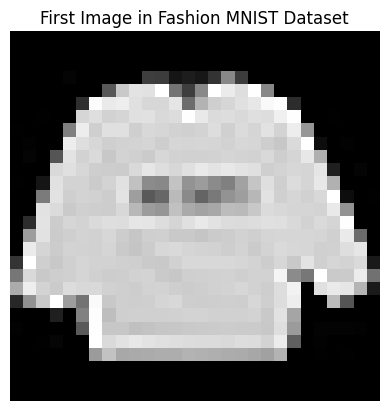

In [17]:
# 첫 번째 이미지 준비
first_image = train_df.iloc[0, 1:].values  # 첫 번째 행에서 label을 제외한 픽셀 데이터만 추출
first_image = first_image.reshape(28, 28)  # 28x28 형태로 변환

# 첫 번째 이미지 표시
plt.imshow(first_image, cmap='gray')
plt.title("First Image in Fashion MNIST Dataset")
plt.axis('off')
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [18]:
# 레이블과 이미지 데이터를 분리
x_train = train_df.iloc[:, 1:].values / 255.0  # 정규화
y_train = train_df.iloc[:, 0].values
x_test = test_df.iloc[:, 1:].values / 255.0
y_test = test_df.iloc[:, 0].values

# Tensor로 변환
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# TensorDataset과 DataLoader 생성
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

## 주요 이미지 전처리 기법

정규화(Normalization): 각 채널의 평균과 표준편차를 사용하여 데이터를 정규화합니다. <br>
랜덤 회전(Random Rotation): 이미지를 무작위로 회전하여 모델이 다양한 각도에 대해 학습하도록 합니다. <br>
수평 뒤집기(Random Horizontal Flip): 이미지를 무작위로 좌우 반전하여 학습 데이터의 다양성을 높입니다.

In [19]:
# 데이터 전처리 변환 정의
transform = transforms.Compose([
    transforms.RandomRotation(10),             # -10도에서 +10도 사이로 회전
    transforms.RandomHorizontalFlip(),         # 수평 뒤집기
    transforms.Normalize((0.5,), (0.5,))      # 정규화 (평균=0.5, 표준편차=0.5)
])

# 커스텀 Dataset 클래스
class CustomTensorDataset(TensorDataset):
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index] # 입력 이미지
        y = self.tensors[1][index] # 레이블
        if self.transform:
            x = self.transform(x) #전처리 적용
        return x, y

    def __len__(self):
        return len(self.tensors[0])


# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

| 구분                | 특성                     | **PCA**                                                                                                      | **t-SNE**                                                                                                                |
|---------------------|--------------------------|-------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| **차원 축소 방식**  | 수학적 기법              | 선형 변환을 사용하여 데이터를 주성분으로 투영합니다. 데이터의 공분산을 최대화하는 방향(주성분)을 찾아 투영합니다. | 확률적 방법으로 데이터의 고차원 공간 내 관계를 저차원 공간에서 근사화합니다. 고차원 공간과 저차원 공간에서 각각 점들 사이의 유사도를 확률 분포로 변환하여, 이를 최대한 비슷하게 유지하려고 합니다. |
|                     | 데이터 간 관계           | 전역적(글로벌) 구조를 잘 보존합니다. 전체 데이터의 분산을 설명하는 방향을 찾기 때문에, 데이터의 전반적인 분포 구조가 유지됩니다. | 국소적(로컬) 구조를 잘 보존합니다. 즉, 데이터 간 근접한 관계(이웃 관계)를 더 잘 반영하여 군집 구조를 효과적으로 표현합니다. |
| **주요 목표**       | 주요 목표                | 최대한 많은 분산을 유지하여 데이터를 투영하는 것이 목표입니다. 차원 축소 후에도 데이터의 변동성을 최대한 반영하려고 합니다. | 데이터의 국소적 유사성을 보존하여 고차원 공간에서 가까운 데이터는 저차원에서도 가깝게, 멀리 떨어진 데이터는 떨어지게 배치합니다. |
|                     | 차원 축소 목적           | 데이터를 설명할 수 있는 주요 축(주성분)을 찾는 데 집중합니다.                                                | 데이터의 클러스터(군집) 구조를 잘 드러내는 데 집중합니다. 특히, 시각화할 때 각 군집을 구별하기 좋습니다. |
| **해석 가능성**     | 주성분 해석 가능성       | PCA의 주성분은 각 축의 방향과 중요도를 나타내기 때문에, 데이터의 주요 특성에 대한 해석이 가능합니다. 예를 들어, 주성분이 높은 비중을 차지하는 피처가 데이터를 설명하는 주요한 요인임을 알 수 있습니다. | t-SNE의 결과로 얻은 각 차원의 축은 특정한 의미를 가지지 않으며, 상대적인 데이터 분포를 시각화하는 용도로 사용됩니다. 따라서, 각 차원에 대한 구체적인 해석은 어렵습니다. |
|                     | 결과 해석의 직관성       | 각 주성분의 기여도를 계산하여 데이터의 분포와 방향성을 파악할 수 있어 해석이 쉽습니다.                       | t-SNE는 데이터를 시각화하는 데 유용하지만, 고차원 데이터의 전반적인 분포를 설명하기에는 부족하며, 개별 축의 의미를 알 수 없습니다. |
| **데이터의 선형성** | 선형성 가정              | 선형 변환을 가정하므로, 데이터가 선형 관계에 있을 때 효과적입니다. 비선형 구조의 데이터에서는 정보를 충분히 반영하지 못할 수 있습니다. | 비선형 구조를 포함한 고차원 데이터에 대해 잘 작동합니다. 따라서 복잡한 구조의 데이터에서도 패턴을 잘 찾아낼 수 있습니다. |
|                     | 적합한 데이터 특성       | 선형적으로 분포된 데이터. 예를 들어, 금융 데이터나 센서 데이터 등에서 데이터의 주요 축을 찾는 데 유용합니다. | 이미지, 텍스트 등의 비선형 구조가 많은 데이터. 예를 들어, 이미지 분류에서 고차원 이미지 간 유사성을 보존하는 데 적합합니다. |
| **계산 효율 및 속도** | 계산 효율성            | 계산이 비교적 빠르며, 큰 데이터셋에도 효율적으로 적용할 수 있습니다. 주로 고유값 분해 또는 특이값 분해(SVD)를 사용하여 계산하기 때문에, 데이터셋이 커져도 효율적입니다. | 계산 비용이 크며, 특히 데이터셋이 클 경우 수행 시간이 길어질 수 있습니다. 고차원 데이터의 유사성을 확률적으로 계산해야 하기 때문에 더 많은 연산이 필요합니다. |
|                     | 적용 가능 데이터 크기    | 수백만 개 이상의 샘플에도 효율적으로 작동할 수 있습니다.                                                     | 수천 개에서 수만 개 샘플이 적합하며, 더 큰 데이터셋에는 시간이 오래 걸립니다. |
| **사용 목적**       | 사용 목적                | 데이터의 주요 축을 찾고, 분산이 높은 방향으로 차원을 축소하여 데이터의 주요 특성을 분석하는 데 적합합니다.      | 데이터 시각화 및 군집화, 특히 고차원 데이터의 군집 관계를 저차원에서 쉽게 파악하고자 할 때 사용합니다. |
|                     | 주요 사용 사례           | 데이터의 특성을 설명하거나, 노이즈가 적고 선형적 구조를 가진 데이터를 다룰 때 적합합니다. 예) 신호 분석, 금융 데이터 요약 | 이미지나 텍스트 데이터의 군집 시각화와 같이 복잡한 비선형 관계를 파악하고자 할 때 적합합니다. 예) 이미지 클러스터링, 문서 시각화 |


## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [20]:
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)

x_train_pca.shape

(60000, 50)

### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [21]:
# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each principal component:")
print(explained_variance_ratio)

Explained variance ratio for each principal component:
[0.29011353 0.17727668 0.060227   0.04970272 0.03839289 0.03470997
 0.02344044 0.01913937 0.01343605 0.01310725 0.0098979  0.0091405
 0.00765206 0.00660427 0.00609188 0.00591506 0.00552046 0.0053049
 0.00459959 0.00455534 0.00432823 0.00406103 0.00383469 0.00374221
 0.00361877 0.0035091  0.00333586 0.00318696 0.00309619 0.00295278
 0.00276008 0.00265339 0.00262962 0.0025768  0.0024756  0.00238413
 0.00230075 0.00224349 0.00219128 0.00209739 0.00200786 0.00197572
 0.00194214 0.00183776 0.00175782 0.0017155  0.00168051 0.00163924
 0.00162221 0.00156039]


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [22]:
# 축소된 차원을 원래 차원으로 복원
x_train_reconstructed = pca.inverse_transform(x_train_pca)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(x_train, x_train_reconstructed)
print("Reconstruction Error (MSE):", reconstruction_error)

Reconstruction Error (MSE): 0.0119395729794383


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [23]:
# PCA 모델 생성 및 30개 주성분으로 차원 축소
pca = PCA(n_components=30)
x_train_pca = pca.fit_transform(x_train)

# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each of the 30 principal components:")
print(explained_variance_ratio)

# 누적된 설명된 분산 비율 (총 설명된 분산 비율 확인)
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("\nCumulative explained variance ratio:")
print(cumulative_variance_ratio)

# 축소된 차원을 원래 차원으로 복원
x_train_reconstructed = pca.inverse_transform(x_train_pca)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(x_train, x_train_reconstructed)
print("\nReconstruction Error (MSE):", reconstruction_error)

Explained variance ratio for each of the 30 principal components:
[0.29011353 0.17727668 0.060227   0.04970272 0.03839289 0.03470997
 0.02344044 0.01913937 0.01343605 0.01310725 0.0098979  0.0091405
 0.00765206 0.00660427 0.00609188 0.00591506 0.00552046 0.0053049
 0.00459959 0.00455534 0.00432823 0.00406103 0.00383469 0.00374221
 0.00361877 0.0035091  0.00333586 0.00318696 0.00309619 0.00295278]

Cumulative explained variance ratio:
[0.29011353 0.46739022 0.52761721 0.57731993 0.61571282 0.65042278
 0.67386322 0.6930026  0.70643865 0.7195459  0.7294438  0.7385843
 0.74623636 0.75284063 0.75893251 0.76484756 0.77036802 0.77567292
 0.7802725  0.78482785 0.78915608 0.79321711 0.7970518  0.80079401
 0.80441278 0.80792187 0.81125773 0.81444469 0.81754088 0.82049366]

Reconstruction Error (MSE): 0.015592261069047406


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

차원을 줄였을 때, 원본 데이터로 복원했을 때의 재구성 오차가 50차원에서 더 작습니다. 이는 50차원으로 축소한 데이터가 원본 데이터를 더 잘 근사할 수 있음을 의미합니다.

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [24]:
# PCA 모델 생성 및 2개 주성분으로 차원 축소
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each of the 2 principal components:")
print(explained_variance_ratio)

# 누적된 설명된 분산 비율 (총 설명된 분산 비율 확인)
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("\nCumulative explained variance ratio:")
print(cumulative_variance_ratio)

# 축소된 차원을 원래 차원으로 복원
x_train_reconstructed = pca.inverse_transform(x_train_pca)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(x_train, x_train_reconstructed)
print("\nReconstruction Error (MSE):", reconstruction_error)

Explained variance ratio for each of the 2 principal components:
[0.29011353 0.17727668]

Cumulative explained variance ratio:
[0.29011353 0.46739022]

Reconstruction Error (MSE): 0.04626349591544639


### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

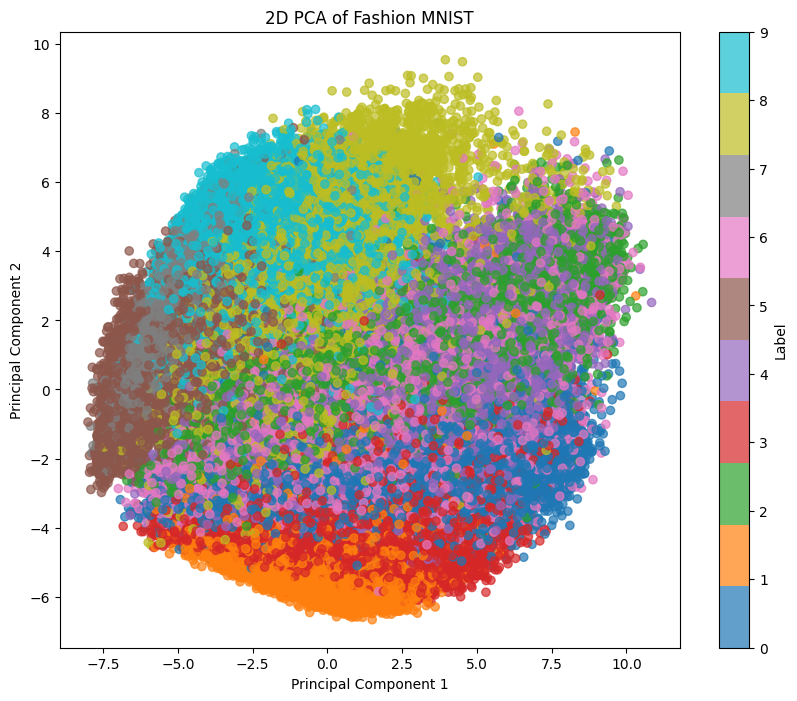

In [25]:
# 2차원 PCA 결과 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Label")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA of Fashion MNIST")
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [ ]:
# 50차원으로 PCA 적용
pca = PCA(n_components=50)
x_train_pca_50 = pca.fit_transform(x_train)

# t-SNE로 2차원으로 축소
tsne = TSNE(n_components=2, random_state=0)
x_train_tsne = tsne.fit_transform(x_train_pca_50)

# t-SNE 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of PCA-reduced (50D) Fashion MNIST")
plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [ ]:
# 30차원으로 PCA 적용
pca = PCA(n_components=30)
x_train_pca_50 = pca.fit_transform(x_train)

# t-SNE로 2차원으로 축소
tsne = TSNE(n_components=2, random_state=0)
x_train_tsne = tsne.fit_transform(x_train_pca_50)

# t-SNE 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_train, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of PCA-reduced (50D) Fashion MNIST")
plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [ ]:
x_train = train_df.iloc[:, 1:].values  # 784차원 데이터를 가져옵니다.

# PCA 모델 생성 및 50개 주성분으로 차원 축소
pca = PCA(n_components=50)
x_train_pca_50 = pca.fit_transform(x_train)

# DBSCAN 군집화
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(x_train_pca_50)

# 군집화 결과 출력
print("DBSCAN Cluster Labels:", dbscan_labels)

### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [ ]:
# KMeans 군집화 (군집 개수 = 10)
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans_labels = kmeans.fit_predict(x_train_pca_50)

# 군집화 결과 출력
print("KMeans Cluster Labels:", kmeans_labels)

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

In [ ]:
# 엘보우 메소드를 위한 KMeans 실행 및 관성 (inertia) 값 저장
inertia = []
cluster_range = range(1, 15)

# 엘보우 메소드 시각화
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(cluster_range)
plt.show()

### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.


(더블클릭해서 이곳에 작성)